In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from model import *
from loss import *

sys.path.append(str(Path().resolve().parent))
from task1_utils.batch_preprocess import ctpn_collate_fn, get_yolo_augmentations


import sys
import os

sys.path.insert(0,  os.path.dirname(os.path.dirname(os.getcwd()) ))

from Dataset import SROIEDataset
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from tqdm import tqdm


In [13]:
def collate_fn_ctpn_padded_correct(batch):
    """
    Collate function с паддингом И правильным учетом координат bboxes.
    """
    images_list = [item['image'] for item in batch]
    boxes_list = [item['boxes'] for item in batch]
    scale_factors_list = [item['scale_factors'] for item in batch]
    
    # 1. Находим максимальные размеры в батче
    max_h = max(img.shape[1] for img in images_list)
    max_w = max(img.shape[2] for img in images_list)
    
    batch_size = len(images_list)
    C = images_list[0].shape[0]
    
    # 2. Создаем тензоры для паддингнутых изображений
    images_tensor = torch.zeros(
        (batch_size, C, max_h, max_w),
        dtype=images_list[0].dtype
    )
    
    # 3. Словарь для хранения смещений каждого изображения
    # Нужно для коррекции bboxes
    padding_info = []
    
    # 4. Заполняем изображения и запоминаем смещения
    for i, img in enumerate(images_list):
        C_i, H_i, W_i = img.shape
        
        # Копируем изображение в левый верхний угол
        images_tensor[i, :, :H_i, :W_i] = img
        
        # Сохраняем информацию о паддинге для этого изображения
        padding_info.append({
            'original_height': H_i,
            'original_width': W_i,
            'padded_height': max_h,
            'padded_width': max_w,
            'pad_top': 0,      # Паддинг сверху = 0 (изображение вверху)
            'pad_left': 0,     # Паддинг слева = 0 (изображение слева)
            'pad_bottom': max_h - H_i,  # Паддинг снизу
            'pad_right': max_w - W_i    # Паддинг справа
        })
    
    # 5. Паддинг для bboxes (МАКСИМАЛЬНО ВАЖНО!)
    max_boxes = max(len(b) for b in boxes_list)
    
    boxes_tensor = torch.zeros(
        (batch_size, max_boxes, 4),
        dtype=boxes_list[0].dtype if boxes_list else torch.float32
    )
    
    boxes_mask = torch.zeros((batch_size, max_boxes), dtype=torch.bool)
    
    for i, boxes in enumerate(boxes_list):
        if len(boxes) > 0:
            # БЕЗ ИЗМЕНЕНИЙ! Координаты уже правильные
            # Так как изображение в левом верхнем углу
            boxes_tensor[i, :len(boxes)] = boxes
            boxes_mask[i, :len(boxes)] = True
    
    # 6. Возвращаем ВСЮ информацию
    return {
        'images': images_tensor,          # [B, C, max_H, max_W]
        'boxes': boxes_tensor,            # [B, max_boxes, 4] - координаты ОТНОСИТЕЛЬНО ИЗОБРАЖЕНИЯ
        'boxes_mask': boxes_mask,         # [B, max_boxes]
        'texts': [item['texts'] for item in batch],
        'image_ids': [item['image_id'] for item in batch],
        'scale_factors': torch.stack(scale_factors_list),  # [B, 2]
        'original_quads': [item['original_quads'] for item in batch],
        'padding_info': padding_info,     # НОВОЕ: информация о паддинге
        'original_sizes': [(img.shape[1], img.shape[2]) for img in images_list]  # (H, W) до паддинга
    }


transform = get_yolo_augmentations()
train_dataset = SROIEDataset('train','../../data/train/img','../../data/train/box',  transform=transform)
val_dataset = SROIEDataset('val','../../data/train/img','../../data/train/box',  transform=transform)
test_dataset = SROIEDataset(None, '../../data/test/img','../../data/test/box', transform=transform)


sub_train_dataset = [train_dataset[i] for i in range(5)]
sub_val_dataset = [train_dataset[i] for i in range(3)]

train_loader = DataLoader(sub_train_dataset, batch_size=1, collate_fn=collate_fn_ctpn_padded_correct,)
val_loader = DataLoader(sub_val_dataset, batch_size=1, collate_fn=collate_fn_ctpn_padded_correct,)





In [14]:
len(train_dataset), len(val_dataset), len(test_dataset)

(563, 63, 347)

In [15]:

def prepare_full_ctpn_targets(batch, anchor_generator):
    """Таргеты для CTPN модели с использованием CTPNAnchors"""
    
    images = batch['images']
    boxes_list = batch['boxes']
    B, C, H_img, W_img = images.shape
    
    # Размер feature map
    feat_h = H_img // anchor_generator.stride
    feat_w = W_img // anchor_generator.stride
    
    # Инициализируем таргеты
    cls_targets = torch.zeros(B, feat_h, feat_w, anchor_generator.num_anchors, dtype=torch.float32)
    reg_targets = torch.zeros(B, feat_h, feat_w, anchor_generator.num_anchors, 2, dtype=torch.float32)
    side_targets = torch.zeros(B, feat_h, feat_w, anchor_generator.num_anchors, 2, dtype=torch.float32)
    
    for b_idx in range(B):
        boxes = boxes_list[b_idx]
        
        # Используем anchor_targets из CTPNAnchors
        targets = anchor_generator.anchor_targets(
            gt_boxes=boxes,
            feature_shape=(feat_h, feat_w),
            img_shape=(H_img, W_img)
        )
        
        # Копируем результаты
        cls_targets[b_idx] = targets['cls_targets']
        reg_targets[b_idx] = targets['reg_targets']
        side_targets[b_idx] = targets['side_targets']
    
    return {
        'cls_targets': cls_targets,      # [B, H, W, K]
        'reg_targets': reg_targets,      # [B, H, W, K, 2]
        'side_targets': side_targets     # [B, H, W, K, 2]
    }

In [20]:
import matplotlib.pyplot as plt
def show_samples_loader_ctpn(data_loader):
    """
    Визуализация для CTPN DataLoader с collate_fn_ctpn.
    """
    batch = next(iter(data_loader))
    
    # Теперь images - это список тензоров
    images = batch['images']
    boxes_list = batch['boxes']
    
    num_samples = min(1, len(images))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(0, num_samples):
        img_tensor = images[i]  # [C, H, W]
        boxes = boxes_list[i]   # [N, 4]
        
        # Конвертируем
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
        
        axes[i].imshow(img_np)
        
        if isinstance(boxes, torch.Tensor):
            boxes = boxes.cpu().numpy()
        
        for box in boxes:
            if len(box) >= 4:
                x1, y1, x2, y2 = box[:4]
                axes[i].add_patch(
                    plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                 fill=False, edgecolor='red', linewidth=2)
                )
        
        axes[i].set_title(f'Image {i+1}\nSize: {img_tensor.shape[1]}x{img_tensor.shape[2]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

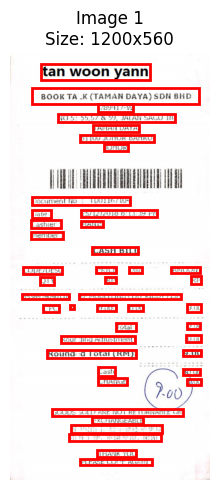

In [21]:
show_samples_loader_ctpn(train_loader)

In [7]:
CTPN()


CTPN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [8]:

def train_epoch(model, dataloader, criterion, optimizer, device, epoch, generator, num_anchors=10):
    """Одна эпоха обучения для полной CTPN модели"""
    model.train()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')
    
    for batch_idx, batch in enumerate(progress_bar):
            # Перенос изображений на устройство
            
            images = batch['images'].to(device)

            # Подготовка полных таргетов для CTPN
            gt_data = prepare_full_ctpn_targets(
                batch, 
                generator=generator
            )
            
            # Forward pass - получаем 3 выхода
            optimizer.zero_grad()
            cls_pred, reg_pred, side_pred = model(images)
            
            # Проверка размеров (для отладки)
            B, C_cls, H_cls, W_cls = cls_pred.shape
   
            cls_target = gt_data['cls_targets']
            reg_target = gt_data['reg_targets']
            side_target = gt_data['side_targets']
            
        
            # Проверяем соответствие размеров
            expected_h = 40  # feature map height
            expected_w = 40  # feature map width
            
            if H_cls != expected_h or W_cls != expected_w:
                print(f"  WARNING: cls_pred имеет размер {H_cls}x{W_cls}, ожидалось {expected_h}x{expected_w}")
                # Делаем ресайз если нужно
                cls_pred = F.interpolate(cls_pred, size=(expected_h, expected_w), mode='bilinear')
                reg_pred = F.interpolate(reg_pred, size=(expected_h, expected_w), mode='bilinear')
                side_pred = F.interpolate(side_pred, size=(expected_h, expected_w), mode='bilinear')
            
            # Вычисление loss
            losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
            
            # Backward pass
            losses['total'].backward()
            
            # Gradient clipping (важно для RNN)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            # Optimizer step
            optimizer.step()
            
            # Статистика
            total_loss += losses['total'].item()
            cls_loss_sum += losses['cls'].item()
            reg_loss_sum += losses['reg'].item()
            side_loss_sum += losses['side'].item()
            
            # Обновление progress bar
            progress_bar.set_postfix({
                'loss': losses['total'].item(),
                'cls': losses['cls'].item(),
                'reg': losses['reg'].item(),
                'side': losses['side'].item()
            })
            

    # Вычисляем средние losses за эпоху
    num_batches = max(len(dataloader), 1)
    avg_total_loss = total_loss / num_batches
    avg_cls_loss = cls_loss_sum / num_batches
    avg_reg_loss = reg_loss_sum / num_batches
    avg_side_loss = side_loss_sum / num_batches
    
    return avg_total_loss, avg_cls_loss, avg_reg_loss, avg_side_loss


In [9]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=10, num_anchors=10):
    """
    Обучение модели CTPN с сохранением лучшей модели по валидации
    """
    # Перемещаем модель на устройство
    model = model.to(device)
    generator = CTPNAnchors(
    anchor_heights=[4, 7, 11, 18, 28, 44, 70, 110, 170, 260],  # Для чеков
    stride=16,
    width=16
    )
    # История обучения
    history = {
        'train_total': [], 'train_cls': [], 'train_reg': [], 'train_side': [],
        'val_total': [], 'val_cls': [], 'val_reg': [], 'val_side': [],
        'best_val_loss': float('inf'),
        'best_epoch': 0
    }
    
    # Общий прогресс-бар для эпох
    epoch_pbar = tqdm(range(num_epochs), desc='Training', unit='epoch')
    
    for epoch in epoch_pbar:
        epoch_num = epoch + 1
        
        # Обучение
        train_losses = train_epoch(
            model, train_loader, criterion, optimizer, 
            device, epoch_num, generator
        )
        avg_total_loss, avg_cls_loss, avg_reg_loss, avg_side_loss = train_losses
        
        # Валидация
        val_losses = validate_epoch(
            model, val_loader, criterion, device, generator
        )
        val_total, val_cls, val_reg, val_side = val_losses
        
        # Сохраняем историю
        history['train_total'].append(avg_total_loss)
        history['train_cls'].append(avg_cls_loss)
        history['train_reg'].append(avg_reg_loss)
        history['train_side'].append(avg_side_loss)
        
        history['val_total'].append(val_total)
        history['val_cls'].append(val_cls)
        history['val_reg'].append(val_reg)
        history['val_side'].append(val_side)
        
        # Сохраняем лучшую модель
        if val_total < history['best_val_loss']:
            history['best_val_loss'] = val_total
            history['best_epoch'] = epoch_num
            
            # Сохраняем модель
            torch.save({
                'epoch': epoch_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_total_loss,
                'val_loss': val_total,
                'history': history
            }, 'best_ctpn_model.pth')
        
        # Обновляем описание progress bar
        epoch_pbar.set_postfix({
            'train_loss': f'{avg_total_loss:.4f}',
            'val_loss': f'{val_total:.4f}',
            'best_val': f'{history["best_val_loss"]:.4f}',
            'best_ep': history['best_epoch']
        })

    
    # Визуализация
    visualize_training(history)
    
    print(f"\nОбучение завершено! Лучшая эпоха: {history['best_epoch']} (val_loss: {history['best_val_loss']:.4f})")
    
    return model, history

def train_epoch(model, dataloader, criterion, optimizer, device, epoch, generator, num_anchors=10):
    """Одна эпоха обучения для полной CTPN модели"""
    model.train()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    
    # Progress bar для батчей
    batch_pbar = tqdm(dataloader, desc=f'Epoch {epoch} - Training', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        try:

            images = batch['images'].to(device)
            
            gt_data = prepare_full_ctpn_targets(batch,anchor_generator=generator,)
            
            optimizer.zero_grad()
            cls_pred, reg_pred, side_pred = model(images)
            
            # Вычисление loss
            losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
            
            # Backward pass
            losses['total'].backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            # Optimizer step
            optimizer.step()
            
            # Статистика
            total_loss += losses['total'].item()
            cls_loss_sum += losses['cls'].item()
            reg_loss_sum += losses['reg'].item()
            side_loss_sum += losses['side'].item()
            
            # Обновление progress bar
            batch_pbar.set_postfix({
                'loss': f"{losses['total'].item():.4f}",
                'cls': f"{losses['cls'].item():.4f}",
                'reg': f"{losses['reg'].item():.4f}",
                'side': f"{losses['side'].item():.4f}"
            })
            
        except Exception as e:
            batch_pbar.write(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Средние значения
    num_batches = max(len(dataloader), 1)
    avg_total = total_loss / num_batches
    avg_cls = cls_loss_sum / num_batches
    avg_reg = reg_loss_sum / num_batches
    avg_side = side_loss_sum / num_batches
    
    return avg_total, avg_cls, avg_reg, avg_side

def validate_epoch(model, val_loader, criterion, device, generator, num_anchors=10):
    """Валидационная эпоха"""
    model.eval()
    total_loss = 0
    cls_loss_sum = 0
    reg_loss_sum = 0
    side_loss_sum = 0
    num_batches = 0
    
    # Progress bar для валидации
    val_pbar = tqdm(val_loader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for batch in val_pbar:
            try:
                
 

                images = batch['images'].to(device)

                gt_data = prepare_full_ctpn_targets(batch, anchor_generator=generator)
                
                cls_pred, reg_pred, side_pred = model(images)
                losses = criterion(cls_pred, reg_pred, side_pred, gt_data)
                
                total_loss += losses['total'].item()
                cls_loss_sum += losses['cls'].item()
                reg_loss_sum += losses['reg'].item()
                side_loss_sum += losses['side'].item()
                num_batches += 1
                
                val_pbar.set_postfix({
                    'loss': f"{losses['total'].item():.4f}",
                    'cls': f"{losses['cls'].item():.4f}"
                })
                
            except Exception as e:
                val_pbar.write(f"Validation error: {e}")
                continue
    
    if num_batches == 0:
        return 0, 0, 0, 0
    
    avg_total = total_loss / num_batches
    avg_cls = cls_loss_sum / num_batches
    avg_reg = reg_loss_sum / num_batches
    avg_side = side_loss_sum / num_batches
    
    return avg_total, avg_cls, avg_reg, avg_side

def visualize_training(history):
    """Визуализация истории обучения"""
    epochs = range(1, len(history['train_total']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Total loss
    axes[0, 0].plot(epochs, history['train_total'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_total'], 'r-', label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Classification loss
    axes[0, 1].plot(epochs, history['train_cls'], 'b-', label='Train')
    axes[0, 1].plot(epochs, history['val_cls'], 'r-', label='Val')
    axes[0, 1].set_title('Classification Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Regression loss
    axes[1, 0].plot(epochs, history['train_reg'], 'b-', label='Train')
    axes[1, 0].plot(epochs, history['val_reg'], 'r-', label='Val')
    axes[1, 0].set_title('Regression Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Side refinement loss
    axes[1, 1].plot(epochs, history['train_side'], 'b-', label='Train')
    axes[1, 1].plot(epochs, history['val_side'], 'r-', label='Val')
    axes[1, 1].set_title('Side Refinement Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ctpn_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

                                                  
Training:   0%|          | 0/2 [00:00<?, ?epoch/s]       

Error in batch 0: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.


                                                  
Training:   0%|          | 0/2 [00:00<?, ?epoch/s, train_loss=0.0000, val_loss=0.0000, best_val=0.0000, best_ep=1]

Validation error: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.


                                                                                                                  
Training:   0%|          | 0/2 [00:00<?, ?epoch/s, train_loss=0.0000, val_loss=0.0000, best_val=0.0000, best_ep=1]

Error in batch 0: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.


                                                                                                                  
Training: 100%|██████████| 2/2 [00:00<00:00, 18.37epoch/s, train_loss=0.0000, val_loss=0.0000, best_val=0.0000, best_ep=1]


Validation error: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.


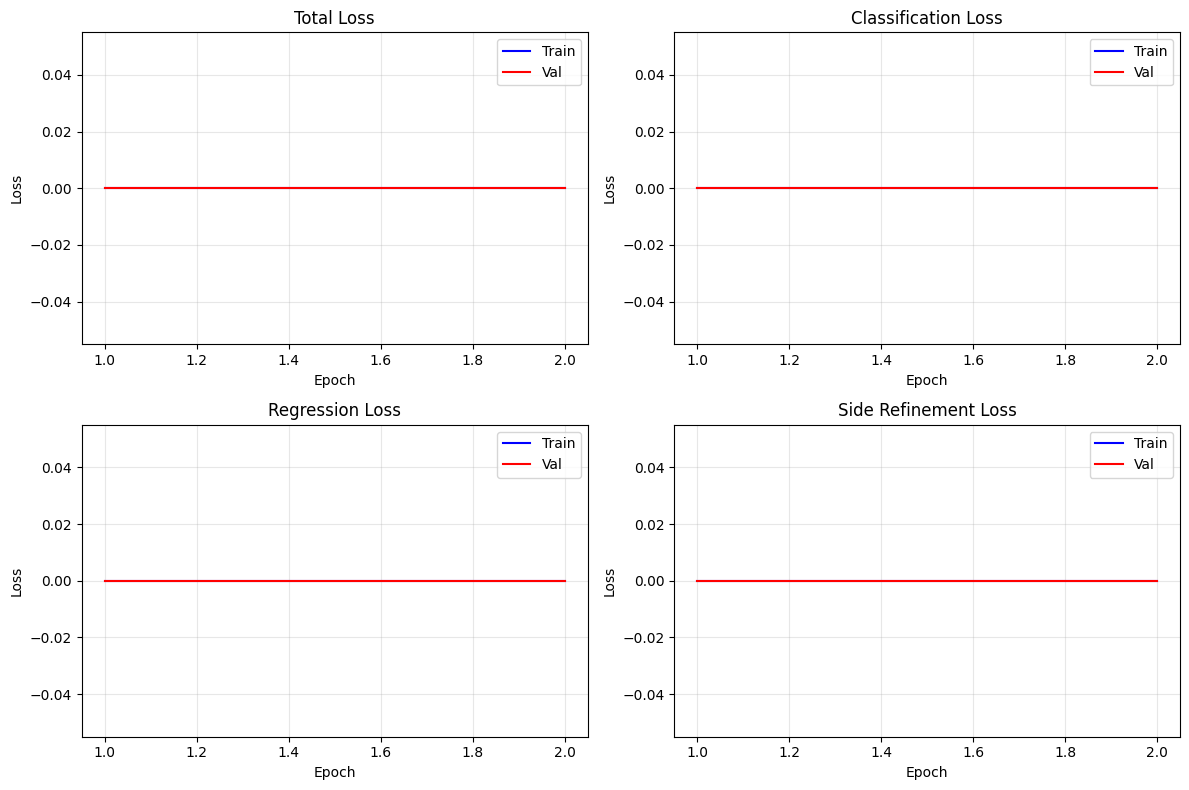


Обучение завершено! Лучшая эпоха: 1 (val_loss: 0.0000)


In [10]:
model = CTPN()
criterion = CTPNLossSimple()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=2,
        num_anchors=10
    )

In [11]:
def test_model_output_shape(model, dataloader, device):
    """Тест размера выходов модели"""
    model.eval()
    batch = next(iter(dataloader))
    images = batch['images'].to(device)
    
    with torch.no_grad():
        cls_pred, reg_pred, side_pred = model(images)
    
    print(f"Input shape: {images.shape}")  # [B, 3, H, W]
    print(f"cls_pred shape: {cls_pred.shape}")  # Должно быть [B, 20, H//16, W//16]
    print(f"reg_pred shape: {reg_pred.shape}")  # Должно быть [B, 20, H//16, W//16]
    print(f"side_pred shape: {side_pred.shape}")  # Должно быть [B, 20, H//16, W//16]
    
    # Проверь размеры feature map
    H_img, W_img = images.shape[2:]
    H_feat, W_feat = H_img // 16, W_img // 16
    
    print(f"\nExpected feature map size: {H_feat}x{W_feat}")
    print(f"Actual cls_pred feature map: {cls_pred.shape[2]}x{cls_pred.shape[3]}")
    
    return cls_pred.shape[2:] == (H_feat, W_feat)

# Вызови эту функцию
is_correct = test_model_output_shape(model, train_loader, device)
if not is_correct:
    print("ERROR: Model output shape is wrong!")

Input shape: torch.Size([2, 3, 1200, 560])
cls_pred shape: torch.Size([2, 20, 75, 35])
reg_pred shape: torch.Size([2, 20, 75, 35])
side_pred shape: torch.Size([2, 20, 75, 35])

Expected feature map size: 75x35
Actual cls_pred feature map: 75x35


In [12]:
def test_anchor_generator_output(dataloader):
    anchor_generator = CTPNAnchors(
    anchor_heights=[4, 7, 11, 18, 28, 44, 70, 110, 170, 260],  # Для чеков
    stride=16,
    width=16
    )
    batch = next(iter(dataloader))
    images = batch['images']
    boxes_list = batch['boxes']
    
    B, C, H_img, W_img = images.shape
    H_feat, W_feat = H_img // 16, W_img // 16
    
    for b_idx in range(B):
        targets = anchor_generator.anchor_targets(
            gt_boxes=boxes_list[b_idx],
            feature_shape=(H_feat, W_feat),
            img_shape=(H_img, W_img)
        )
        
        print(f"Batch {b_idx}:")
        print(f"  cls_targets shape: {targets['cls_targets'].shape}")
        print(f"  reg_targets shape: {targets['reg_targets'].shape}")
        print(f"  side_targets shape: {targets['side_targets'].shape}")
        
        # КРИТИЧЕСКОЕ: Проверь размеры
        assert targets['cls_targets'].shape == (H_feat, W_feat, anchor_generator.num_anchors)
        assert targets['reg_targets'].shape == (H_feat, W_feat, anchor_generator.num_anchors, 2)
        assert targets['side_targets'].shape == (H_feat, W_feat, anchor_generator.num_anchors, 2)


test_anchor_generator_output(train_loader)

RuntimeError: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.

In [13]:
history

{'train_total': [0.0, 0.0],
 'train_cls': [0.0, 0.0],
 'train_reg': [0.0, 0.0],
 'train_side': [0.0, 0.0],
 'val_total': [0, 0],
 'val_cls': [0, 0],
 'val_reg': [0, 0],
 'val_side': [0, 0],
 'best_val_loss': 0,
 'best_epoch': 1}

In [14]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_text_detections_ctpn(model, dataloader, device, score_thresh=0.7, num_samples=3):
    """
    Визуализация предсказаний CTPN модели на нескольких сэмплах
    
    Args:
        model: Обученная CTPN модель
        dataloader: DataLoader с данными (новый формат)
        device: CUDA/CPU устройство
        score_thresh: Порог для отбора детекций
        num_samples: Количество сэмплов для визуализации
    """
    model.eval()
    
    # Получаем батч из dataloader
    batch = next(iter(dataloader))
    batch_size = len(batch['images'])
    
    # Ограничиваем количество сэмплов для визуализации
    num_samples = min(num_samples, batch_size)
    
    # Anchors высоты (на входном изображении)
    anchor_heights = [11, 16, 23, 33, 48, 68, 97, 139, 198, 283]
  
    num_anchors = len(anchor_heights)
    stride = 16  # CTPN stride
    
    # Создаем фигуру
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for sample_idx in range(num_samples):
        # Подготавливаем изображение для модели
        image_tensor = batch['images'][sample_idx:sample_idx+1].to(device)
        
        # Получаем оригинальные данные
        image_np = batch['images'][sample_idx].cpu().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        
        # Денормализуем если нужно
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)
        
        # Конвертируем BGR -> RGB
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        
        # Создаем копии для визуализации
        gt_img = image_rgb.copy()
        pred_img = image_rgb.copy()
        
        # --- 1. Отрисовываем Ground Truth ---
        gt_boxes = batch['boxes'][sample_idx]
        if isinstance(gt_boxes, torch.Tensor):
            gt_boxes = gt_boxes.cpu().numpy()
        
        gt_count = 0
        for box in gt_boxes:
            if len(box) >= 4:
                x1, y1, x2, y2 = map(int, box[:4])
                # Проверяем валидность координат
                if x2 > x1 and y2 > y1:
                    cv2.rectangle(gt_img, (x1, y1), (x2, y2), 
                                 color=(255, 0, 0), thickness=2)
                    gt_count += 1
        
        # --- 2. Получаем предсказания модели ---
        with torch.no_grad():
            cls_pred, reg_pred, side_pred = model(image_tensor)
        
        # Получаем вероятности классов
        cls_probs = torch.softmax(cls_pred, dim=1)
        B, C, H_feat, W_feat = cls_probs.shape
        
        # Reshape предсказаний для удобства
        cls_probs_reshaped = cls_probs.view(B, H_feat, W_feat, num_anchors, 2)
        positive_scores = cls_probs_reshaped[..., 1]
        
        # Для каждой позиции берем лучший anchor
        max_scores, best_anchors = positive_scores[0].max(dim=-1)
        
        # --- 3. Отрисовываем предсказания ---
        pred_count = 0
        for y in range(H_feat):
            for x in range(W_feat):
                score = max_scores[y, x].item()
                
                if score > score_thresh:
                    pred_count += 1
                    a_idx = best_anchors[y, x].item()
                    
                    # Получаем регрессионные параметры
                    dy = reg_pred[0, a_idx*2, y, x].item()
                    dh = reg_pred[0, a_idx*2 + 1, y, x].item()
                    
                    # Получаем side refinement
                    dx_left = side_pred[0, a_idx*2, y, x].item()
                    dx_right = side_pred[0, a_idx*2 + 1, y, x].item()
                    
                    # Вычисляем координаты proposal'а
                    # Центр ячейки на исходном изображении
                    cell_center_x = (x + 0.5) * stride
                    cell_center_y = (y + 0.5) * stride
                    anchor_h = anchor_heights[a_idx]
                    
                    # Применяем регрессию для центра и высоты
                    pred_center_y = cell_center_y + dy * anchor_h
                    pred_height = anchor_h * np.exp(dh)
                    
                    # Вычисляем границы по Y
                    y1 = pred_center_y - pred_height / 2
                    y2 = pred_center_y + pred_height / 2
                    
                    # Применяем side refinement для границ по X
                    x1 = cell_center_x + dx_left * stride
                    x2 = cell_center_x + dx_right * stride
                    
                    # Конвертируем в целые числа
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                    
                    # Проверяем валидность координат
                    if x2 > x1 and y2 > y1:
                        # Ограничиваем размерами изображения
                        h, w = image_rgb.shape[:2]
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)
                        
                        # Рисуем bounding box
                        cv2.rectangle(pred_img, (x1, y1), (x2, y2), 
                                     color=(0, 255, 0), thickness=2)
                        
                        # Добавляем score
                        score_text = f"{score:.2f}"
                        cv2.putText(pred_img, score_text, (x1, max(0, y1-5)),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        
        # --- 4. Отображаем результаты ---
        # Ground Truth
        axes[sample_idx, 0].imshow(gt_img)
        axes[sample_idx, 0].set_title(f'Sample {sample_idx+1}: Ground Truth\n{gt_count} boxes', 
                                     fontsize=12)
        axes[sample_idx, 0].axis('off')
        
        # Predictions
        axes[sample_idx, 1].imshow(pred_img)
        axes[sample_idx, 1].set_title(f'Sample {sample_idx+1}: Predictions\n{pred_count} detections (thresh={score_thresh})', 
                                     fontsize=12)
        axes[sample_idx, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
    return gt_img, pred_img

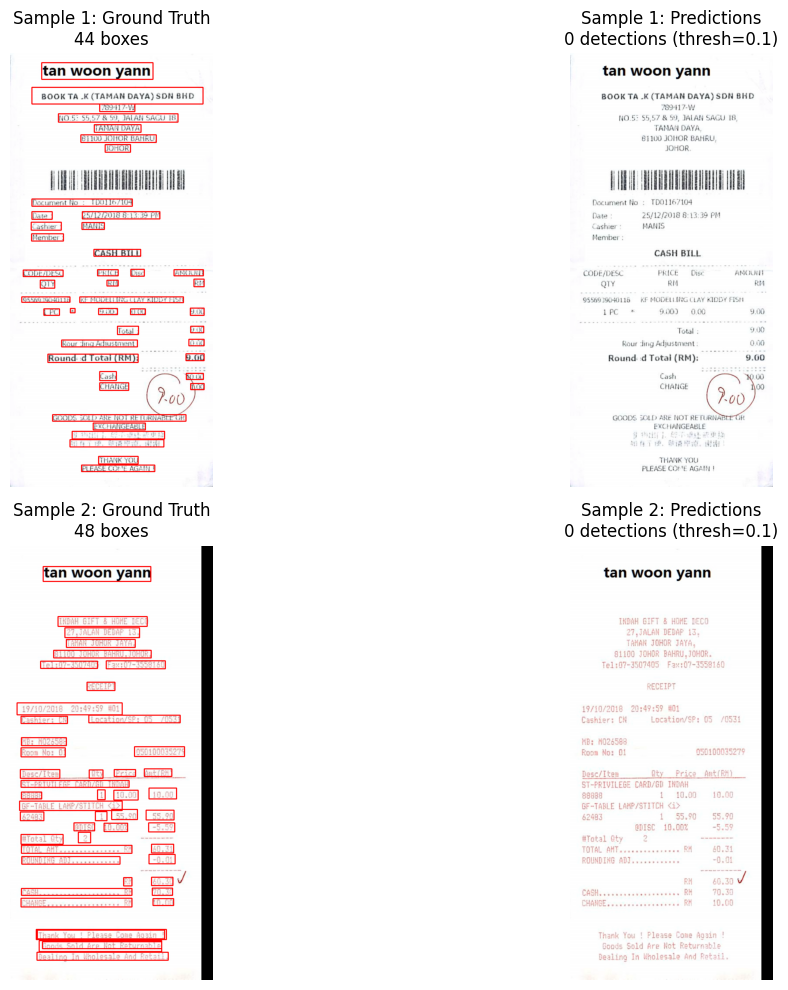

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  0,   0,   0],
  

In [15]:
visualize_text_detections_ctpn(model, train_loader, device, 0.1)

In [ ]:
for b in val_loader:
    print(b.keys())

dict_keys(['images', 'boxes', 'original_quads', 'texts', 'image_ids', 'original_sizes', 'scale_factors'])
dict_keys(['images', 'boxes', 'original_quads', 'texts', 'image_ids', 'original_sizes', 'scale_factors'])


# TODO на завтра:

- скопировать ноутбук и основные зависимости на коллаб (model, loss, data)

- подготовить train / val / test 

- написать функцию, что будет сохранять best_model на активации

- прогнать обучение на 5-10 эпохах

- визуализировать бест модель

- rename DataLoader